In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn import preprocessing
import time

## Load and clean Data

In [3]:
HIGH_QUAL_DIR = 'F:\High_Quality\\' 
TEST_SET_DIR = 'F:\Cell_Line\\'

files_dir = HIGH_QUAL_DIR 
file_paths = listdir(files_dir) 

df = cu.combine_csvs(files_dir, file_paths)

df.dropna(axis='index', how='all', inplace=True) # drop any rows where all values are missing
df = df.drop(['\n'])

original_df = df.copy()

In [4]:
mq.log2_normalize(df)

df_min = df.min().min()
impute_val = df_min/2
df = df.fillna(impute_val)

# median normalize
mq.median_normalize(df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


In [5]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)

column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)

## Set up Cell Line data

In [6]:
finalized_model_folder = r'Trained_Models\\'

features_path = finalized_model_folder + 'train_features'

features_to_keep = joblib.load(open(features_path, 'rb'))

In [7]:
NUM_SPLITS = 100

test_paths = listdir(TEST_SET_DIR) 
test_data = cu.combine_csvs(TEST_SET_DIR, test_paths)

test_labels = []
for col in test_data.columns.values.tolist():
    for tissue in tissues:
        if col.startswith(tissue):
            test_labels.append(tissue)
            continue
            
original_test_data = test_data.copy()
test_data = cu.fit_new_data(original_df, test_data, features_to_keep)

C:\Users\kush494\Documents\Proteomics_Data_Processing\Classifiers\Classification_Utils.py:523: RuntimeWarning: divide by zero encountered in log2
  fitted_data.iloc[:,:] = np.log2(fitted_data.iloc[:,:])


In [8]:
test_labels

['Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver',
 'Liver']

## Load classifiers

In [9]:
svc = joblib.load(open(finalized_model_folder + 'svc_highqual_crossval_25Percentile.sav', 'rb'))
lr = joblib.load(open(finalized_model_folder + 'lr_highqual_crossval_25Percentile.sav', 'rb'))
mnb = joblib.load(open(finalized_model_folder + 'mnb_highqual_crossval_25Percentile.sav', 'rb'))
gnb = joblib.load(open(finalized_model_folder + 'gnb_highqual_crossval_25Percentile.sav', 'rb'))
rf = joblib.load(open(finalized_model_folder + 'rf_highqual_crossval_25Percentile.sav', 'rb'))
gbc = joblib.load(open(finalized_model_folder + 'gbc_highqual_crossval_25Percentile.sav', 'rb'))
knn = joblib.load(open(finalized_model_folder + 'knn_highqual_crossval_25Percentile.sav', 'rb'))

## Test classifier accuracy on iPS data

In [10]:
mnb_pred = mnb.predict(test_data)
mnb_result = mnb.score(test_data, test_labels)

lr_pred = lr.predict(test_data)
lr_result = lr.score(test_data, test_labels)

svc_pred = svc.predict(test_data)
svc_result = svc.score(test_data, test_labels)

gnb_pred = gnb.predict(test_data)
gnb_result = gnb.score(test_data, test_labels)

gbc_pred = gbc.predict(test_data)
gbc_result = gbc.score(test_data, test_labels)

rf_pred = rf.predict(test_data)
rf_result = rf.score(test_data, test_labels)

knn_pred = knn.predict(test_data)
knn_result = knn.score(test_data, test_labels)

In [11]:
print(lr_result)
print(mnb_result)
print(rf_result)
print(svc_result)
print(gbc_result)
print(gnb_result)
print(knn_result)

0.5
0.0
0.0
0.0
0.4
0.0
0.0


In [12]:
knn_pred

array(['Temporal_Lobe', 'Temporal_Lobe', 'Temporal_Lobe', 'Temporal_Lobe',
       'Temporal_Lobe', 'Temporal_Lobe', 'Temporal_Lobe', 'Temporal_Lobe',
       'Temporal_Lobe', 'Temporal_Lobe'],
      dtype='<U16')

## Confusion Matrix

Confusion matrix, without normalization
[[ 0 10]
 [ 0  0]]
Normalized confusion matrix
[[  0.   1.]
 [ nan  nan]]


C:\Users\kush494\Documents\Proteomics_Data_Processing\Classifiers\Classification_Utils.py:585: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


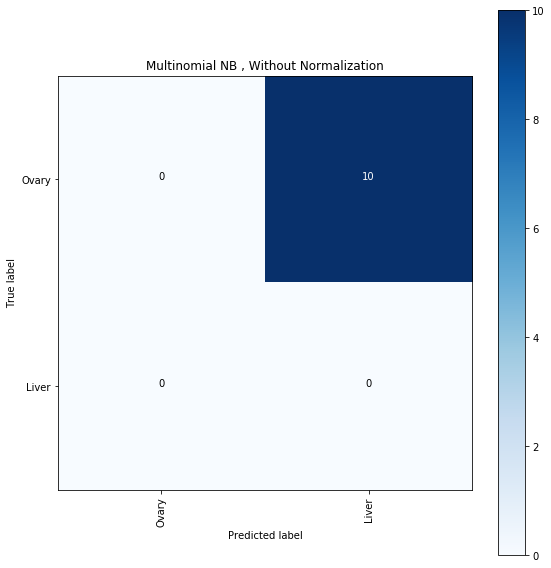

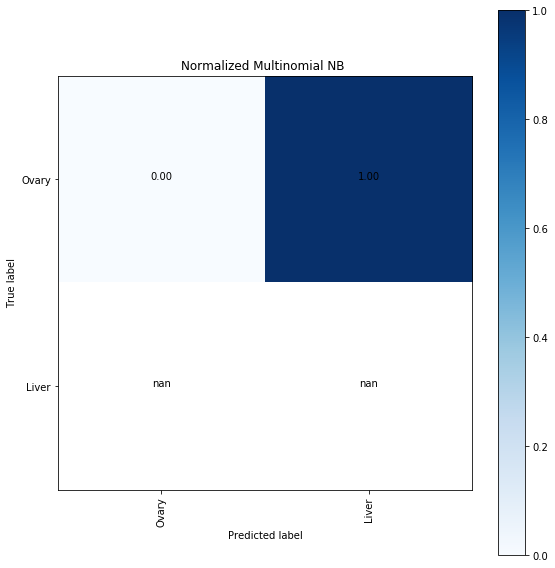

In [13]:
cm_labels = list(set(mnb_pred.tolist() + test_labels))
cu.show_confusion_matrices(test_labels, mnb_pred, cm_labels, 'Multinomial NB ')

## PCA with Cell Line included

In [14]:
### Copy test df, rename to cell_line
original_test_data.columns = cu.rename_columns(original_test_data, 'Liver', 'Liver_Cell_Line')

### join dfs
combined_df = original_df.join(original_test_data, how='outer')
combined_column_names = combined_df.columns.values.tolist()

In [15]:
mq.log2_normalize(combined_df)

combined_df_min = combined_df.min().min()
impute_val = combined_df_min/2
combined_df = combined_df.fillna(impute_val)

# median normalize
mq.median_normalize(combined_df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


In [21]:
combined_tissues = tissues + ['Liver_Cell_Line']

combined_tissues_to_columns = cu.map_tissues_to_columns(combined_df, combined_tissues)
column_to_color = mq.map_colors(combined_tissues, combined_tissues_to_columns, 10, 'Set3')

In [22]:
### 2D and 3D PCA
image_dir = r'D:\Images\Cell_Line\\'

scaled_data = combined_df.T

pca = PCA() # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe

pca_3 = PCA(n_components=3) 
pca_3.fit(scaled_data)
pca_data_3 = pca_3.transform(scaled_data)

per_var, pca_labels = mq.make_scree_plot(pca, image_dir, 'Scree Plot - 25 Percentile')
per_var_3, pca_labels_3 = mq.make_scree_plot(pca_3, image_dir, '3 Dimensional Scree - 25 Percentile')

mq.draw_pca_graph2(combined_column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, 
                   combined_tissues, combined_tissues_to_columns, 'PCA - 25 Percentile')
mq.draw_3d_pca(combined_column_names, pca_data_3, image_dir, column_to_color, per_var_3, pca_labels_3, 
               combined_tissues, combined_tissues_to_columns, '3D PCA - 25 Percentile')

C:\Users\kush494\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
